In [2]:
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn import metrics

In [3]:
data = pd.read_csv('csv/DATASET_3a_global.csv')

//anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head(3)

,bottom,middle,top,users,y,0,1,2,3,4,...,3062,3063,3064,3065,3066,3067,3068,3069,3070,3071
0,PT001AWNYQ43_4094966_1_v1.jpg,IC647EWMWF91_4177819_1_v1.jpg,OO001EWPJQ27_4190535_1_v2.jpg,alex_test,1.0,1.035404,0.269563,0.143173,0.170981,0.308065,...,2.369041,1.575275,2.060973,1.533488,0.000842,0.168519,1.823179,0.331064,0.059062,0.000000
1,CA086AWLTL36_1_v1.jpg,IN002EWLKW42_1_v1.jpg,TO029EWMOQ83_3943245_1_v1.jpg,strak,1.0,1.492683,0.064760,0.071014,0.724826,2.543821,...,0.284060,0.086591,0.774355,1.586183,1.768617,0.440139,0.796940,0.066419,0.019898,0.431429
2,AN003AWKYU95_1_v1.jpg,AL006EWIIB35_1_v1.jpg,BA007EWLBR09_1_v2.jpg,strak,1.0,0.877401,0.075175,1.384997,0.238448,0.599227,...,0.023626,0.081537,0.131171,0.260097,0.030089,0.623181,0.450706,0.000000,0.030349,0.425907


In [5]:
data = data[0:3600]

In [25]:
model = RandomForestClassifier(n_jobs = -1, random_state = 0)
parameter_grid = {
    'n_estimators' : [350, 500, 600],
    'max_depth' : [3, 4, 5, 7],
    'min_samples_split' : [2, 4, 8],
    'min_samples_leaf' : [1, 2, 5],
}

In [26]:
from sklearn.cross_validation import train_test_split

train_X, test_X, train_Y,test_Y = train_test_split(data.drop(['y','bottom', 'middle', 'top', 'users'],1), data.y, test_size=0.3, random_state=42)

In [27]:
random_search_roc_auc = GridSearchCV(model, parameter_grid, scoring='accuracy', 
                                   cv = cross_validation.StratifiedShuffleSplit(train_Y, n_iter = 3, test_size = 0.3),
                                  )

In [28]:
%%time
random_search_roc_auc.fit(train_X, train_Y)

CPU times: user 1h 48min, sys: 1min 50s, total: 1h 49min 51s
Wall time: 44min 33s


GridSearchCV(cv=StratifiedShuffleSplit(labels=[ 0.  1. ...,  0.  0.], n_iter=3, test_size=0.3, random_state=None),
       error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [350, 500, 600], 'min_samples_split': [2, 4, 8], 'max_depth': [3, 4, 5, 7], 'min_samples_leaf': [1, 2, 5]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [29]:
best_params_roc_auc = random_search_roc_auc.best_params_
print best_params_roc_auc

{'min_samples_split': 2, 'n_estimators': 350, 'max_depth': 7, 'min_samples_leaf': 5}


In [30]:
%%time
final_model_roc_auc = RandomForestClassifier(n_jobs = -1, random_state = 0, **best_params_roc_auc)
final_model_roc_auc.fit(train_X, train_Y)

CPU times: user 28.3 s, sys: 285 ms, total: 28.6 s
Wall time: 10.5 s


In [21]:
%%time
final_model_roc_auc = RandomForestClassifier(n_jobs = -1, random_state = 0, n_estimators = 500, max_depth = 5)
final_model_roc_auc.fit(train_X, train_Y)

CPU times: user 24.3 s, sys: 375 ms, total: 24.6 s
Wall time: 10.2 s


In [31]:
print 'negative ' + str(len(data[data.y == 0]))
print 'positive ' + str(len(data[data.y == 1]))
print sum(train_Y)                 #class 1
print len(train_Y) - sum(train_Y)   #class 0
print sum(test_Y)
print len(test_Y) - sum(test_Y)

negative 1782
positive 1818
1246.0
1274.0
572.0
508.0


In [32]:
score = pd.DataFrame(data = [[metrics.accuracy_score(train_Y, final_model_roc_auc.predict(train_X)), metrics.accuracy_score(test_Y, final_model_roc_auc.predict(test_X))],
                             [metrics.roc_auc_score(train_Y, final_model_roc_auc.predict(train_X)), metrics.roc_auc_score(test_Y, final_model_roc_auc.predict(test_X))],
                            [metrics.average_precision_score(train_Y, final_model_roc_auc.predict(train_X)), metrics.average_precision_score(test_Y, final_model_roc_auc.predict(test_X))]])
score.index = ['accuracy','roc_auc','average_precision_score']
score.columns = ['train','test']

In [33]:
score

,train,test
accuracy,0.951984,0.723148
roc_auc,0.951789,0.726743
average_precision_score,0.967155,0.811038


In [34]:
print metrics.classification_report(test_Y, final_model_roc_auc.predict(test_X))

             precision    recall  f1-score   support

        0.0       0.68      0.79      0.73       508
        1.0       0.78      0.67      0.72       572

avg / total       0.73      0.72      0.72      1080



Populating the interactive namespace from numpy and matplotlib


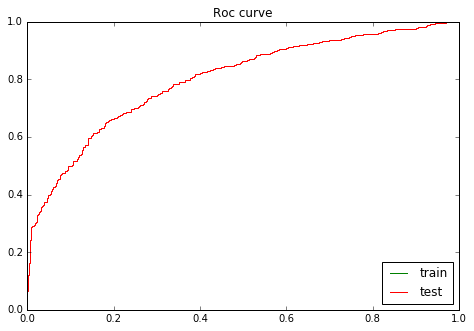

In [58]:
%matplotlib inline
%pylab inline
fpr_test, tpr_test, _test = metrics.roc_curve(test_Y, final_model_roc_auc.predict_proba(test_X)[:,1])
fpr_train, tpr_train, _train = metrics.roc_curve(train_Y, final_model_roc_auc.predict_proba(train_X)[:,1])
pylab.axes([0.0,0.0,1,1])
pylab.plot(fpr_train ,tpr_train, color = 'green', label = 'train')
pylab.plot(fpr_test ,tpr_test, color = 'red', label = 'test')
pylab.title('Roc curve')
pylab.legend(loc = "lower right")

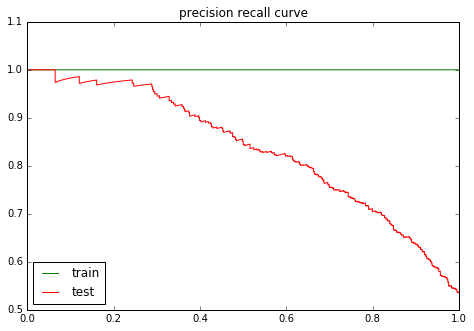

In [59]:
precision_test, recall_test, thresholds_test = metrics.precision_recall_curve(test_Y, final_model_roc_auc.predict_proba(test_X)[:,1])
precision_train, recall_train, thresholds_train = metrics.precision_recall_curve(train_Y, final_model_roc_auc.predict_proba(train_X)[:,1])
pylab.axes([0.0,0.0,1,1])
pylab.plot(recall_train ,precision_train, color = 'green', label = 'train')
pylab.plot(recall_test ,precision_test, color = 'red', label = 'test')
pylab.title('precision recall curve')
pylab.legend(loc = "lower left")


In [60]:
train_data = pd.DataFrame(data = numpy.asarray([train_Y.index, train_Y, final_model_roc_auc.predict(train_X)]).T, columns = ['index','real_y','predict_y'])
test_data = pd.DataFrame(data = numpy.asarray([test_Y.index, test_Y, final_model_roc_auc.predict(test_X)]).T, columns = ['index','real_y','predict_y'])

In [61]:
train_data.to_csv('csv/train_global_all_users.csv')
test_data.to_csv('csv/test_global_all_users.csv')

In [62]:
pd.DataFrame(random_search_roc_auc.grid_scores_)

,parameters,mean_validation_score,cv_validation_scores
0,"{u'n_estimators': 150, u'min_samples_split': 4...",0.689418,"[0.694444444444, 0.693121693122, 0.68783068783..."
1,"{u'n_estimators': 200, u'min_samples_split': 2...",0.713228,"[0.695767195767, 0.747354497354, 0.70238095238..."
2,"{u'n_estimators': 500, u'min_samples_split': 4...",0.722487,"[0.723544973545, 0.724867724868, 0.73015873015..."
3,"{u'n_estimators': 200, u'min_samples_split': 2...",0.704762,"[0.687830687831, 0.716931216931, 0.70238095238..."
4,"{u'n_estimators': 600, u'min_samples_split': 2...",0.667725,"[0.674603174603, 0.689153439153, 0.66666666666..."
5,"{u'n_estimators': 200, u'min_samples_split': 8...",0.722751,"[0.695767195767, 0.715608465608, 0.74603174603..."
6,"{u'n_estimators': 150, u'min_samples_split': 8...",0.719048,"[0.731481481481, 0.732804232804, 0.71164021164..."
